# 95% Confidence Monte Carlo Experiments

In [1]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from project import preprocessing, rf_models, mc_experiments

In [4]:
df_re = pd.read_csv("../data/re_custody_2017_gsprs.csv", low_memory=False)

## [Initial Custody] Building Random Forest With Original Data

In [5]:
df = preprocessing.preprocess_input_vars_re(df_re)
data = df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "re_custody_level",
        "ic_custdy_level",
        "prior_commits",
        "re_discip_reports",
        "re_escp_hist_1",
        "re_escp_hist_2",
        "re_escp_hist_3",
        "re_escp_hist_4",
        "re_escp_hist_5",
        "control_number"
    ]
]
data = data[data["re_custody_level"] > 1]
data = data.dropna()

In [6]:
len(data)

14573

In [7]:
X = data.drop(["control_number", "re_custody_level"], axis=1)
Y = data["re_custody_level"]

In [8]:
# Create random forest with original data
re_rf_model = rf_models.BasicRFModel(X, Y)
re_rf_model.fit()

In [9]:
re_col_enumerated = {
    col: dict(data.groupby(["re_custody_level"])[col].apply(list))
    for col in data.drop("re_custody_level", axis=1) 
}

In [10]:
re_col_enumerated_2lvl = {
    col: dict(data.groupby([
        "re_custody_level",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"])[col].apply(list))
    for col in data.drop([
        "re_custody_level",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"], axis=1) 
}

## [Reclass Custody] 95% Confidence Interval Sampling Experiment

Grouping by the initial custody level and Only perturbing `off_1_prs_max`, `off_1_gs_max`,
`prior_commits`, `ic_institut_adj` according to their 95% confidence intervals.

In [11]:
re_95conf_1lvl_fn = mc_experiments.gen_95conf_super_sampling_fn(
    col_enumerated = re_col_enumerated,
    multi_lvl = False,
    const_cols = [
        "control_number",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "re_escp_hist_1",
        "re_escp_hist_2",
        "re_escp_hist_3",
        "re_escp_hist_4",
        "re_escp_hist_5"
    ]
)

In [12]:
re_95conf_1lvl_sampling_mc = mc_experiments.MCExp(data, "re_custody_level", re_rf_model)

In [13]:
re_95conf_1lvl_sampling_mc.run_sim(
    N=100,
    sampling_fn=re_95conf_1lvl_fn,
    ignore_vars=[ "control_number" ]
)

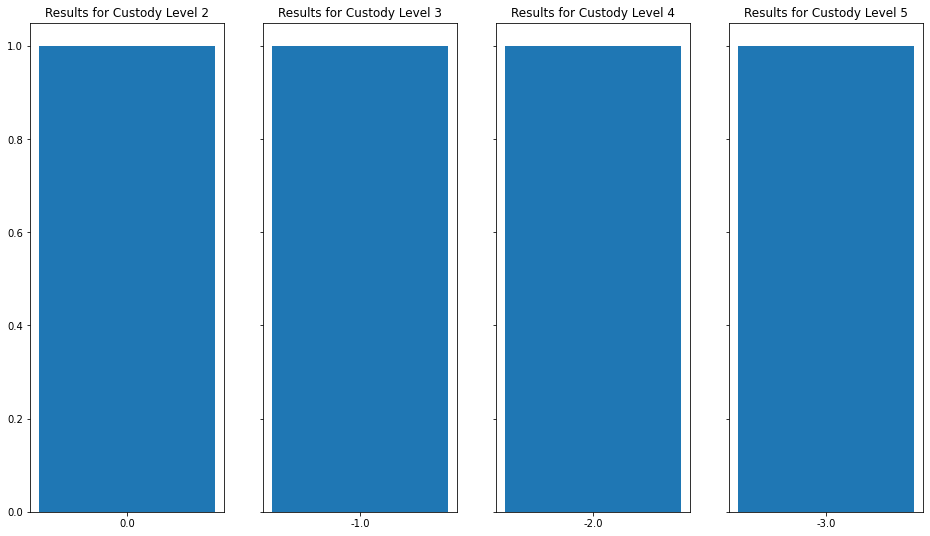

In [14]:
re_95conf_1lvl_sampling_mc.plot_result_hist(True, save_to="../paper/images/re_95conf_mc.png")